## BERT on Email Classification
#### This program is used to utilize BERT to verify whether it can improve the performance of supporting email classification in my firm.
####  The detail of BERT can be found in: https://github.com/google-research/bert

This program is consisted of the following:
1. Data preparation for run_classifier.py in BERT: <br />
 1) Load the supporting email data and divide those into 3 files: train.tsv, dev.tsv, test.tsv, 
which is required by run_classifier.py in the sample of BERT.<br />
 2) Revise run_classifier.py with the label list. <br />
 3) After run run_classifer.py for the training / testing, then compare the result of test result.<br />
2. Build the similiar DL structure by keras and compare the result with 1 to see the feasiblity of BERT application. <br />

In addition, the source file in this program was not uploaded, and the audience can create your own by MS excel file, in which, 2 columns, one for input question ( Data x), and one for label ( Data y).

In [116]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [117]:
import itertools
import os
import logging
import csv        

%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding,LSTM,Flatten,GRU,Bidirectional
from keras.preprocessing import text, sequence
from keras import utils

import gensim
from gensim.models import Word2Vec
from gensim.models import FastText

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

You have TensorFlow version 1.12.0


### Load the dataset

In [118]:
source = pd.read_excel('../98_data/mail_timesheet_admin_woissue.xlsx', encoding='latin-1')
source.head()

,convid,subject,length,tousflag,dialognm,forwardtime,imagenm,notimagenm,mailbody,mailquestion,imagetype,firstanswername,firstforwardname,Category,Unnamed: 14
0,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,NaN,26.5,1,3.0,1,0,0,now personname change target date and able to ...,i can not find anything related to this after ...,NaN,yosong@abeam.com,yosong@abeam.com,Timesheet,NaN
4,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,NaN,21.0,1,1.5,0,0,0,we think it was caused by google bar in your b...,hi nasa team i had a problem which accessing t...,NaN,yosong@abeam.com,NaN,Authorization,NaN
22,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,10 15,12.0,1,1.5,0,0,0,staff 9 tel 9 9 fax 9 9 mailto emailaddress fs...,staff 9 tel 9 9 fax 9 9 mailto emailaddress fs...,NaN,NaN,NaN,Timesheet,NaN
26,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,ab my new finance cum project executive erica ...,72.0,1,0.0,0,0,0,i would like to take this opportunity to intro...,i would like to take this opportunity to intro...,NaN,NaN,NaN,Others,NaN
27,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,abeam consulting sap implementation for yan wa...,10.0,1,6.5,0,0,0,let s discuss with you soon please in 30 min ....,let s discuss with you soon please in 30 min ....,NaN,NaN,NaN,Others,NaN


In [119]:
# Rename the columns
df=source[['mailquestion','Category']]
df.columns=['Emails','Cat']
df = df[pd.notnull(df['Emails'])]
df.head()

,Emails,Cat
0,i can not find anything related to this after ...,Timesheet
4,hi nasa team i had a problem which accessing t...,Authorization
22,staff 9 tel 9 9 fax 9 9 mailto emailaddress fs...,Timesheet
26,i would like to take this opportunity to intro...,Others
27,let s discuss with you soon please in 30 min ....,Others


In [120]:
df.isnull().sum()

Emails    0
Cat       0
dtype: int64

In [121]:
df['Cat'].value_counts()

Timesheet        333
Others           159
Authorization    131
Project          100
Report            56
SAP_HR            15
Subcon            13
Resource           1
Name: Cat, dtype: int64

## 1.  Data Preparation and Test for BERT

### Create train, dev, test files for BERT

In [122]:
# Create the training, dev, test set for BERT:
trans_narrative,test_narrative,trans_product, test_product = train_test_split(df['Emails'], df['Cat'],
                                                                              random_state=42, train_size=0.8)
train_narrative,dev_narrative,train_product, dev_product = train_test_split(trans_narrative, 
                                                                            trans_product,random_state=42,
                                                                            train_size=0.8)

In [123]:
# Since BERT will be run in command window, the files of train, dev, test will be produced for this purposes.
with open('train.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(train_narrative.shape[0]):
        tsv_output.writerow([str(1000+i),train_product.iloc[i],'',train_narrative.iloc[i]])

with open('dev.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(dev_narrative.shape[0]):
        tsv_output.writerow([str(4000+i),dev_product.iloc[i],'',dev_narrative.iloc[i]])

with open('test.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(test_narrative.shape[0]+1):
        if i==0:
            tsv_output.writerow(['index','sentence','label'])
        else:
            tsv_output.writerow([str(6000+i),test_narrative.iloc[i-1],test_product.iloc[i-1]])


In [124]:
# Use sklearn utility to convert label strings to numbered index, and convert it for BERT classification
encoder = LabelEncoder()
encoder.fit(df['Cat'])
# add the following output with comma on each item into the line 378 of run_classifier.py in BERT, then run train it.
print(encoder.classes_)

['Authorization' 'Others' 'Project' 'Report' 'Resource' 'SAP_HR' 'Subcon'
 'Timesheet']


### Evaluate the test results

In [34]:
"""
The process is, running training and testing in command, then back to this block to run the following code.
"""
## After running prediction, the file "test_results.tsv" is produced, which can be used to compare the result
test_result_pd=pd.read_csv('/Users/patrick/documents/github/bert/tmp/BB-8_output/test_results.tsv',
                           sep='\t',header=None)
test_result_pd.columns=['Authorization','Others','Project',
                        'Report','Resource','SAP_HR','Subcon','Timesheet','non-issue']

In [35]:
prediction=pd.DataFrame(test_result_pd.idxmax(axis=1),columns=['prediction'])

In [66]:
prediction=pd.DataFrame({'prediction':test_result_pd.idxmax(axis=1),'probality':np.max(test_result_pd,axis=1)})

In [75]:
# Identify the matchable records in test file for the further investigation or comparison with other algorithms' result.
x=0
for i in range(test_product.shape[0]):
    if prediction.iloc[i][0]==test_product.iloc[i]:
        x +=1
print("Test Accuracy is:",x/i)

test_result_BERT=pd.DataFrame(columns=['index','sentence','label','prediction','matchable','probality'])

with open('test_results_bert.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(test_narrative.shape[0]+1):
        if i==0:
            tsv_output.writerow(['index','sentence','label','prediction','matchable','probality'])
        else:
            if test_product.iloc[i-1]==prediction.iloc[i-1][0]:
                matchable='Y'
            else:
                matchable='N'
            tsv_output.writerow([str(6000+i),test_narrative.iloc[i-1],test_product.iloc[i-1],
                                 prediction.iloc[i-1][0],matchable,prediction.iloc[i-1][1]])
            test_result_BERT.loc[i-1]=[str(6000+i),test_narrative.iloc[i-1],test_product.iloc[i-1],
                                 prediction.iloc[i-1][0],matchable,prediction.iloc[i-1][1]]
    

Test Accuracy is: 0.6459627329192547


In [76]:
test_result_BERT.head(10)

,index,sentence,label,prediction,matchable,probality
0,6001,would you please kindly tell me how to update ...,Others,Others,Y,0.283963
1,6002,timesheets which need your approve have not be...,Timesheet,Timesheet,Y,0.909263
2,6003,staff yoraka stated in submit delay report alr...,Timesheet,Timesheet,Y,0.906963
3,6004,i m not sure whether the message from nasa as ...,Timesheet,Timesheet,Y,0.902591
4,6005,hi when i tried to login on nasa global site l...,Authorization,Authorization,Y,0.410477
5,6006,for the resigned staff nik zhang we need to re...,Timesheet,Timesheet,Y,0.742715
6,6007,to all chua teerin was resigned last month as ...,Timesheet,Timesheet,Y,0.909418
7,6008,because the period is closed so what can i do ...,Timesheet,Others,N,0.308135
8,6009,i could not input project code in expense page...,Report,Project,N,0.430631
9,6010,i have recently posted an billing in nasa and ...,Report,Project,N,0.349714


## 2. Predict the results by MLP to compare the BERT

### Data preparation for MLP

In [143]:
# Find out the maximum words for the dimension of word vectors
def text2word(doc):
    """
    Usage: Convert one text into word list.
    Input: doc - string list
    Output: documents - string list: all sentences in words list.
            text_len - int: maximum numbers of words in one sentense
            max_text - strig list: the words list of the sentence with maximum words
    """
    return_docs=[]
    text_len=0
    max_text=''
    #for item in df['Emails']:
    for item in doc:
        text_words=[word for word in str(item).lower().split()]
        return_docs.append(text_words)
        if len(text_words)> text_len:
            text_len=len(text_words)
            max_text=text_words
    #max_words = text_len
    
    return return_docs,text_len,max_text

documents,max_words,_=text2word(df['Emails'])

# In case the maximum words may be less than coming prediction, the following reset words.
max_words=4000

tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [144]:
#tokenize.fit_on_texts(train_narrative) # only fit on train
tokenize.fit_on_texts(df['Emails'])
x_train = tokenize.texts_to_matrix(train_narrative)
x_dev= tokenize.texts_to_matrix(dev_narrative)
x_test = tokenize.texts_to_matrix(test_narrative)
word_index = tokenize.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3294 unique tokens.


In [145]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_product)
y_train = encoder.transform(train_product)
y_dev = encoder.transform(dev_product)
y_test = encoder.transform(test_product)

In [146]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_dev = utils.to_categorical(y_dev, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [147]:
print(encoder.classes_)

['Authorization' 'Others' 'Project' 'Report' 'Resource' 'SAP_HR' 'Subcon'
 'Timesheet']


In [148]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_dev shape:', x_dev.shape)
print('y_dev shape:', y_dev.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (516, 4000)
x_test shape: (162, 4000)
x_dev shape: (130, 4000)
y_dev shape: (130, 8)
y_train shape: (516, 8)
y_test shape: (162, 8)


### Build the model

In [149]:
# Open questions: why are those parameters used for?
batch_size = 20
hidden_size = 128
epochs = 20
dropout=0.2
# numbers of hidden layers
layers=0

In [150]:
# Build the model
model = Sequential()
model.add(Dense(hidden_size, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(dropout))

for i in range(layers):
    model.add(Dense(hidden_size))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a categorical classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the categorical_crossentropy loss function.
This isn't the only choice for a loss function, you could, for instance, choose mean_squared_error. But, generally, categorical_crossentropy is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.
Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.
Now, configure the model to use an optimizer and a loss function:

In [151]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.optimizer.get_config())
model.summary()

{'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               512128    
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_8 (Activation)    (None, 8)                 0         
Total params: 513,160
Trainable params: 513,160
Non-trainable params: 0
______________________________________________________________

### Train the model

In [152]:

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_dev,y_dev))

Train on 516 samples, validate on 130 samples
Epoch 1/20
516/516 [==============================] - 0s 863us/step - loss: 1.4667 - acc: 0.4884 - val_loss: 1.1140 - val_acc: 0.6077
Epoch 2/20
516/516 [==============================] - 0s 262us/step - loss: 0.8585 - acc: 0.7771 - val_loss: 0.9029 - val_acc: 0.7462
Epoch 3/20
516/516 [==============================] - 0s 253us/step - loss: 0.5666 - acc: 0.8895 - val_loss: 0.7811 - val_acc: 0.7923
Epoch 4/20
516/516 [==============================] - 0s 251us/step - loss: 0.3737 - acc: 0.9380 - val_loss: 0.6968 - val_acc: 0.7923
Epoch 5/20
516/516 [==============================] - 0s 244us/step - loss: 0.2589 - acc: 0.9535 - val_loss: 0.6477 - val_acc: 0.8077
Epoch 6/20
516/516 [==============================] - 0s 247us/step - loss: 0.1908 - acc: 0.9671 - val_loss: 0.6290 - val_acc: 0.8077
Epoch 7/20
516/516 [==============================] - 0s 250us/step - loss: 0.1525 - acc: 0.9729 - val_loss: 0.6132 - val_acc: 0.8154
Epoch 8/20
516/5

### Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [153]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

<IPython.core.display.Javascript object>


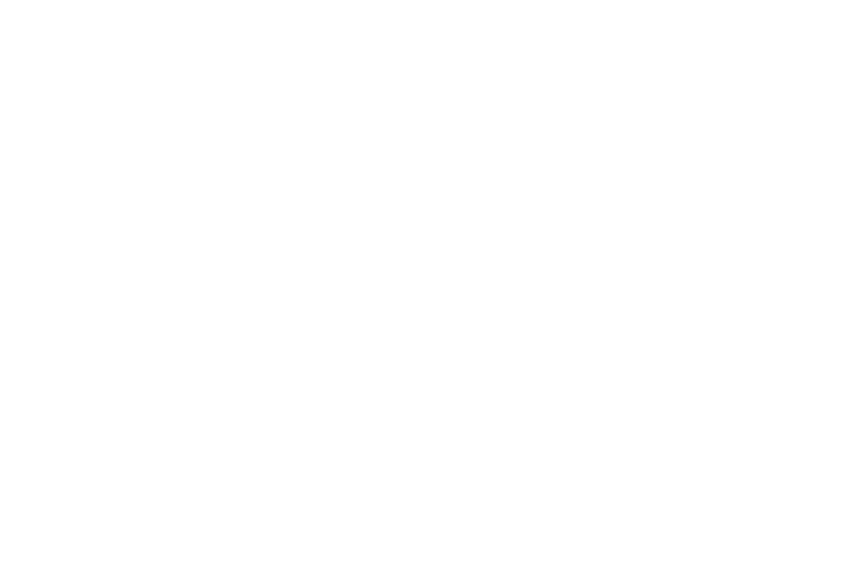

<IPython.core.display.Javascript object>


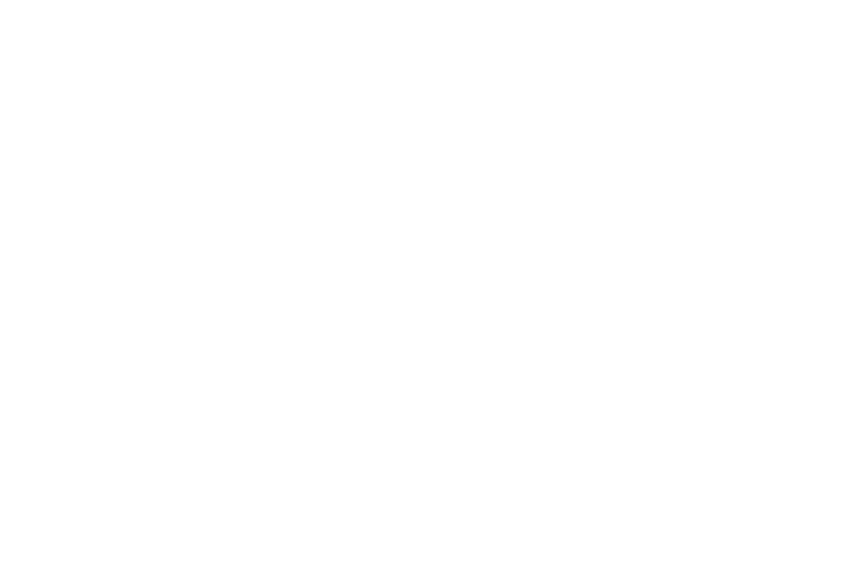

In [154]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


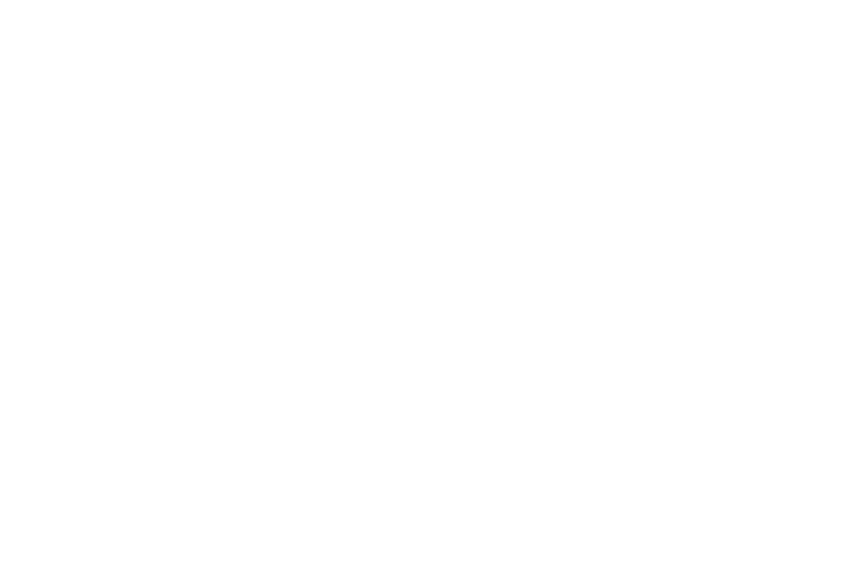

<IPython.core.display.Javascript object>


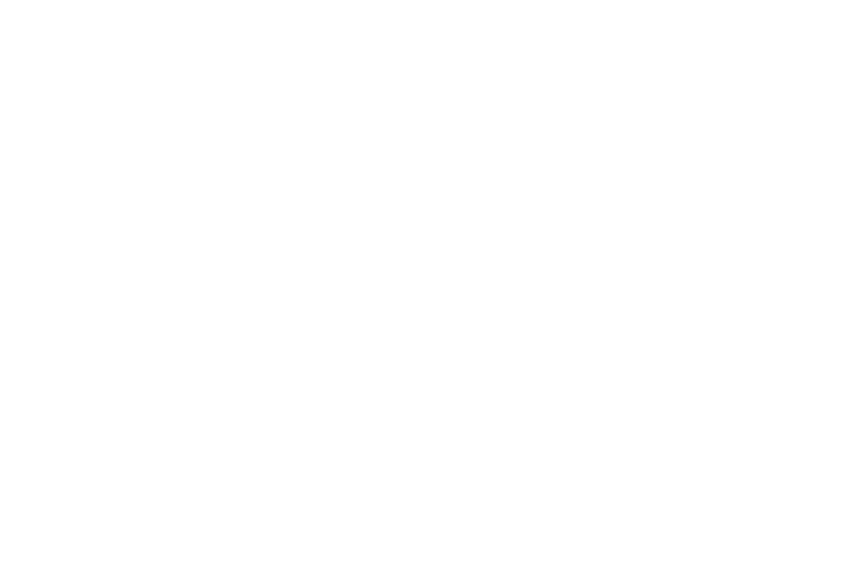

In [155]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [156]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

162/162 [==============================] - 0s 118us/step
Test score: 1.1578260202271242
Test accuracy: 0.7777777836646562


In [157]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('English_model.h5')


In [158]:
# Produce the result of test into one tsv file for the further analysis
y_pred=encoder.classes_[np.argmax(model.predict(x_test,batch_size=batch_size),axis=1)]
y_prob=np.max(model.predict(x_test,batch_size=batch_size),axis=1)
test_result=pd.DataFrame(columns=['index','sentence','label','prediction','matchable','probality'])

with open('test_results.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(test_narrative.shape[0]+1):
        if i==0:
            tsv_output.writerow(test_result.columns)
        else:
            if test_product.iloc[i-1]==y_pred[i-1]:
                matchable='Y'
            else:
                matchable='N'
            tsv_output.writerow([str(6000+i),test_narrative.iloc[i-1],
                                 test_product.iloc[i-1],y_pred[i-1],matchable,y_prob[i-1]])
            test_result.loc[i-1]=[str(6000+i),test_narrative.iloc[i-1],
                                 test_product.iloc[i-1],y_pred[i-1],matchable,y_prob[i-1]]
    

In [159]:
test_result.head(10)

,index,sentence,label,prediction,matchable,probality
0,6001,would you please kindly tell me how to update ...,Others,Others,Y,0.980395
1,6002,timesheets which need your approve have not be...,Timesheet,Timesheet,Y,0.999292
2,6003,staff yoraka stated in submit delay report alr...,Timesheet,Timesheet,Y,0.999994
3,6004,i m not sure whether the message from nasa as ...,Timesheet,Timesheet,Y,0.998018
4,6005,hi when i tried to login on nasa global site l...,Authorization,Others,N,0.717280
5,6006,for the resigned staff nik zhang we need to re...,Timesheet,Timesheet,Y,0.830434
6,6007,to all chua teerin was resigned last month as ...,Timesheet,Timesheet,Y,0.999994
7,6008,because the period is closed so what can i do ...,Timesheet,Timesheet,Y,0.545265
8,6009,i could not input project code in expense page...,Report,Report,Y,0.693662
9,6010,i have recently posted an billing in nasa and ...,Report,Report,Y,0.765001


### Data processing to keep the records satisfying both Algorithms

In [113]:
# Merge both MLP test result and BERT result
test_result_merg=pd.merge(test_result,test_result_BERT,on=['index'])

# Count the total test result for coming combining accuracy's calculation
total_test_records=test_result_merg.shape[0]

# Setup the probability level to keep the records
prob_level=0.8

In [114]:
# Making sure the prediction is same between them
test_result_merg=test_result_merg[test_result_merg['prediction_x']==test_result_merg['prediction_y']]

# Remove unmatchable records
test_result_merg=test_result_merg[test_result_merg['matchable_x']=='Y']
test_result_merg=test_result_merg[test_result_merg['matchable_y']=='Y']

# Remove records less than prob_level
test_result_merg=test_result_merg[test_result_merg['probality_x']>=prob_level]
test_result_merg=test_result_merg[test_result_merg['probality_y']>=prob_level]

In [115]:
print('Percent of remaining:', round(test_result_merg.shape[0]/total_test_records,2))

Percent of remaining: 0.31
